In [12]:
import torch
import torch.nn as nn
import torch.optim as optim

from s4 import S4D
import os
import matplotlib.pyplot as plt
import h5py

import torch
import torch.nn.functional as F

import lava.lib.dl.slayer as slayer
import torch

# Dropout broke in PyTorch 1.11
if tuple(map(int, torch.__version__.split('.')[:2])) == (1, 11):
    print("WARNING: Dropout is bugged in PyTorch 1.11. Results may be worse.")
    dropout_fn = nn.Dropout
if tuple(map(int, torch.__version__.split('.')[:2])) >= (1, 12):
    dropout_fn = nn.Dropout1d
else:
    dropout_fn = nn.Dropout2d

In [13]:
batch_size = 1 
inp_dim = 8 
L = 5 # sequence length
dropout = 0
inp = torch.rand(batch_size, inp_dim, L) 

In [14]:
model = S4D(d_model=inp_dim,
            d_state=1,
            dropout=dropout,
            transposed=True,
            final_act = None,
            activation = None,
            lr=None,
            is_real=True)
model.__name__ = "S4D"
model.setup_step()


class Network(torch.nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        
        sdnn_params = { # sigma-delta neuron parameters
                'threshold'     : 0,    # delta unit threshold
                'tau_grad'      : 0.5,    # delta unit surrogate gradient relaxation parameter
                'scale_grad'    : 1,      # delta unit surrogate gradient scale parameter
                'requires_grad' : False,   # trainable threshold
                'shared_param'  : True,   # layer wise threshold
               # 'activation'    : model, # activation function
            ## 'activation' : F.relu

            }
        sdnn_S4d_params = { # conv layer has additional mean only batch norm
                **sdnn_params,                                 # copy all sdnn_params
                'activation' : model, # mean only quantized batch normalizaton
            }
        sdnn_dense_params = { # dense layers have additional dropout units enabled
                **sdnn_params,                        # copy all sdnn_cnn_params
                'activation' : F.relu
            }
        
        self.blocks = torch.nn.ModuleList([# sequential network blocks 
                #slayer.block.sigma_delta.Input(sdnn_dense_params),
                slayer.block.sigma_delta.Dense(sdnn_S4d_params, inp_dim, inp_dim),
                slayer.block.sigma_delta.Output(sdnn_dense_params, inp_dim, inp_dim)
            ])
    
 
        self.blocks[0].synapse.weight.data = torch.eye(inp_dim).reshape((inp_dim,inp_dim,1,1,1))
        self.blocks[0].synapse.weight.requires_grad = False
        self.blocks[1].synapse.weight.data = torch.eye(inp_dim).reshape((inp_dim,inp_dim,1,1,1))
        self.blocks[1].synapse.weight.requires_grad = False
        
    def forward(self, x):        
        for block in self.blocks: 
            # forward computation is as simple as calling the blocks in a loop
            x = block(x)
        return x

    def grad_flow(self, path):
        # helps monitor the gradient flow
        grad = [b.synapse.grad_norm for b in self.blocks if hasattr(b, 'synapse')]

        plt.figure()
        plt.semilogy(grad)
        plt.savefig(path + 'gradFlow.png')
        plt.close()

        return grad
    
    def export_hdf5(self, filename):
        # network export to hdf5 format
        h = h5py.File(filename, 'w')
        layer = h.create_group('layer')
        for i, b in enumerate(self.blocks):
            b.export_hdf5(layer.create_group(f'{i}'))
        

In [15]:
# Generate output in different ways
import numpy as np

diff_inp = inp[:,:, 1:] - inp[:, :, :-1]
diff_inp = torch.concatenate((inp[:, :, :1], diff_inp), axis=2) 
# Lava-dl output
net = Network()
out_dl = net(diff_inp)

# Original Network
out_original = model(inp)

# Step output
out_step = torch.zeros_like(out_dl)
state = model.default_state(batch_size)
for t in range(L):
    y, state = model.step(inp[:, :, t], state)
    out_step[0, :, t] = y

In [16]:
from lava.lib.dl import netx
net.export_hdf5("test")
loaded_net =  netx.hdf5.Network(net_config='test')
print(loaded_net)

type S4D
activation S4D
vThMant 0
a [0.96103656 0.99918675 0.99832654 0.9989993  0.99673426 0.99282247
 0.99263054 0.9946965 ]
b [-0.05510263 -0.0011501  -0.00236663 -0.00141521 -0.00461845 -0.01015056
 -0.01042199 -0.00750029]
c [ 0.41319188 -0.46516132  0.2549965  -0.5213351  -0.00270985 -0.5251312
 -0.57940406 -0.12845047]
keeeeey
layer
keeeeey
0
Helllooo
keeeeey
type
keeeeey
0
Helllooo
keeeeey
shape
keeeeey
neuron
keeeeey
type
keeeeey
vThMant
keeeeey
a
keeeeey
b
keeeeey
c
keeeeey
weight
neuron_params {'neuron_proc': <class 'lava.proc.s4d.process.SigmaS4dDelta'>, 'vth': 0, 'a': array([0.96103656, 0.99918675, 0.99832654, 0.9989993 , 0.99673426,
       0.99282247, 0.99263054, 0.9946965 ], dtype=float32), 'b': array([-0.05510263, -0.0011501 , -0.00236663, -0.00141521, -0.00461845,
       -0.01015056, -0.01042199, -0.00750029], dtype=float32), 'c': array([ 0.41319188, -0.46516132,  0.2549965 , -0.5213351 , -0.00270985,
       -0.5251312 , -0.57940406, -0.12845047], dtype=float32), 'num_

In [17]:
# get output from loaded lava net
from lava.proc.io.source import RingBuffer as SourceBuffer
from lava.proc.io.sink import RingBuffer as SinkBuffer
from lava.magma.core.run_conditions import RunSteps
from lava.magma.core.run_configs import Loihi2SimCfg
from lava.proc.dense.process import Dense

n_steps = 10
lava_inp = diff_inp.detach().numpy().reshape((inp_dim, L))
print(inp.detach().numpy().shape)

spiker = SourceBuffer(data=lava_inp)
connector = Dense(weights = np.eye(inp_dim))
receiver = SinkBuffer(buffer = n_steps, shape=(inp_dim,))


spiker.s_out.connect(connector.s_in)
connector.a_out.connect(loaded_net.inp)
loaded_net.out.connect(receiver.a_in)


run_cfg = Loihi2SimCfg(select_tag ="floating_pt")
spiker.run(condition=RunSteps(num_steps=n_steps), run_cfg=run_cfg)
    
received_data_lava = receiver.data.get()
spiker.stop()

(1, 8, 5)


[0. 0. 0. 0. 0. 0. 0. 0.]
[ 0. -0.  0. -0. -0. -0. -0. -0.]
[0. 0. 0. 0. 0. 0. 0. 0.]
[ 0. -0.  0. -0. -0. -0. -0. -0.]
[128. 128. 128. 128. 128. 128. 128. 128.]
[-5.82859740e+00  1.36955793e-01 -1.54491499e-01  1.88876053e-01
  3.20392231e-03  1.36457678e+00  1.54586700e+00  2.46634280e-01]
[256. 256. 256. 256. 256. 256. 256. 256.]
[-1.72586900e+01  4.10756000e-01 -4.63215963e-01  5.66439152e-01
  9.60130374e-03  4.08393606e+00  4.62620881e+00  7.38594814e-01]
[384. 384. 384. 384. 384. 384. 384. 384.]
[-3.40720243e+01  8.21289334e-01 -9.25915287e-01  1.13250048e+00
  1.91817153e-02  8.14835383e+00  9.22971716e+00  1.47458052e+00]
[512. 512. 512. 512. 512. 512. 512. 512.]
[-5.60588508e+01  1.36844460e+00 -1.54233180e+00  1.88687139e+00
  3.19347621e-02  1.35481759e+01  1.53451672e+01  2.45329719e+00]
[640. 640. 640. 640. 640. 640. 640. 640.]
[-8.30175923e+01  2.05211068e+00 -2.31220827e+00  2.82936346e+00
  4.78500830e-02  2.02738174e+01  2.29614166e+01  3.67345753e+00]
[768. 768. 768.

tensor([[[0.3567, 0.7859, 0.7992, 0.8704, 0.1123],
         [0.4621, 0.1984, 0.7088, 0.8291, 0.5959],
         [0.8435, 0.8587, 0.9092, 0.6708, 0.8045],
         [0.5290, 0.6741, 0.5005, 0.5133, 0.6113],
         [0.9919, 0.1132, 0.7331, 0.5532, 0.3874],
         [0.9874, 0.9384, 0.2326, 0.0274, 0.4946],
         [0.1804, 0.0903, 0.6388, 0.2009, 0.4079],
         [0.6778, 0.3137, 0.8950, 0.3294, 0.0425]]])
tensor([[[ 0.3567,  0.4293,  0.0133,  0.0712, -0.7581],
         [ 0.4621, -0.2637,  0.5103,  0.1203, -0.2332],
         [ 0.8435,  0.0152,  0.0505, -0.2384,  0.1337],
         [ 0.5290,  0.1451, -0.1737,  0.0129,  0.0979],
         [ 0.9919, -0.8786,  0.6199, -0.1798, -0.1658],
         [ 0.9874, -0.0490, -0.7058, -0.2052,  0.4672],
         [ 0.1804, -0.0901,  0.5484, -0.4378,  0.2069],
         [ 0.6778, -0.3641,  0.5813, -0.5657, -0.2869]]])


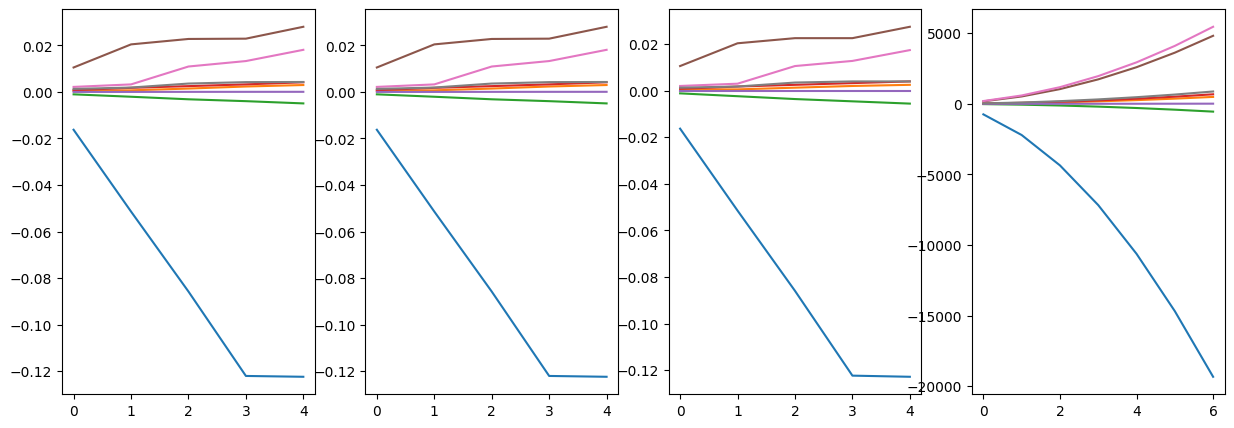

In [18]:
fig, axs = plt.subplots(1, 4, figsize=(15, 5))

print(inp)
print(diff_inp)
axs[0].plot(out_step[0].detach().numpy().T);
axs[1].plot(out_original[0].detach().numpy().T);
axs[2].plot(out_dl[0].detach().numpy().T);
axs[3].plot(received_data_lava[:, 3:].T);